In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import healpy as hp
import urllib.request
import os
import matplotlib.pyplot as plt

This notebook provides some code and a tutorial for jackknifing a full sky convergence map, which can be used to estimate error bars for statistics that are computed on the convergence map.

In [2]:
#here we define some functions
def get_takahashi(url, output_directory, output_filename):
    """
    Downloads and processes the a Takahashi kappa map data file, saving the processed data as a .fits file.

    Parameters
    ----------
    url : str
        The URL to download the Takahashi data file from.
    output_directory : str
        The directory where the downloaded and processed files will be saved.
    output_filename : str
        The name of the file to save the downloaded data as (without the .fits extension).

    Notes
    -----
    This function downloads the file from the specified URL if it does not already exist in the output directory.
    It then reads and processes the file, extracting specific data blocks and saving them into a .fits file.
    """
    
    download_path = f'{output_directory}/{output_filename}'
    if not os.path.exists(download_path):
        urllib.request.urlretrieve(url, download_path)

    filename = f'{output_directory}/{output_filename}'
    save_path = f'{output_directory}/{output_filename}.fits'
    
    if not os.path.exists(save_path):
        skip = [0, 536870908, 1073741818, 1610612728, 2147483638, 2684354547, 3221225457]
        load_blocks = [skip[i+1]-skip[i] for i in range(0, 6)]

        with open(filename, 'rb') as f:
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            nside = np.fromfile(f, dtype='int32', count=1)[0]
            npix = np.fromfile(f, dtype='int64', count=1)[0]
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            print("nside:{} npix:{}".format(nside, npix))

            rec = np.fromfile(f, dtype='uint32', count=1)[0]

            kappa = np.array([])
            r = npix
            for i, l in enumerate(load_blocks):
                blocks = min(l, r)
                load = np.fromfile(f, dtype='float32', count=blocks)
                np.fromfile(f, dtype='uint32', count=2)
                kappa = np.append(kappa, load)
                r = r-blocks
                if r == 0:
                    break
                elif r > 0 and i == len(load_blocks)-1:
                    load = np.fromfile(f, dtype='float32', count=r)
                    np.fromfile(f, dtype='uint32', count=2)
                    kappa = np.append(kappa, load)
        
        hp.fitsfunc.write_map(save_path, kappa)
        
        
def get_patches(npix, nside_patch):
    """
    Generates a mapping from pixels to patches based on HEALPix grid resolution.

    Parameters
    ----------
    npix : int
        The total number of pixels in the original map (at the original nside).
    nside_patch : int
        The nside resolution of the patches.

    Returns
    -------
    ith_pixel_patch : ndarray
        An array where each element indicates the patch index that the corresponding pixel belongs to.
    """
    
    ith_pixel = np.arange(npix)
    npatch = hp.nside2npix(nside_patch)
    ith_patch = np.arange(npatch)
    ith_pixel_angle = hp.pix2ang(hp.npix2nside(npix),ith_pixel)
    ith_pixel_patch = hp.ang2pix(nside_patch,ith_pixel_angle[0],ith_pixel_angle[1])
    
    return ith_pixel_patch


def jackknife_map(kappa, ith_pixel_patch, i):
    """
    Creates a jackknife resampled map by masking out one patch.

    Parameters
    ----------
    kappa : ndarray
        The original data map.
    ith_pixel_patch : ndarray
        An array mapping each pixel to its corresponding patch.
    i : int
        The index of the patch to mask out.

    Returns
    -------
    kappa : ndarray
        The jackknife resampled map, where the selected patch is masked out with `hp.UNSEEN`.
    """
    
    kappa = np.copy(kappa)
    jackknife_filter = ith_pixel_patch == i
    kappa[jackknife_filter] = hp.UNSEEN
    
    return kappa


def get_bins(lower, upper, nbins, return_edges = False):

    binEdges = np.linspace(lower, upper, nbins + 1 ) 
    binMid = ( binEdges[1:] + binEdges[:-1] ) / 2.

    if return_edges:
        return binMid, binEdges
    else:
        return binMid
    
    
    
def find_extrema_jackknife(kappa_map, nside_patch, minima=False, lonlat=False):
    """find extrema in a smoothed masked healpix map
       default is to find peaks, finds minima with minima=True
    
       Parameters
       ----------
       kappa_masked_smooth: MaskedArray (healpy object)
           smoothed masked healpix map for which extrema are to be identified
       minima: bool
           if False, find peaks. if True, find minima
       
       Returns
       -------
       extrema_pos: np.ndarray
           extrema positions on sphere, theta and phi, in radians
       extrema_amp: np.ndarray
           extrema amplitudes in kappa
       
    """

    #first create an array of all neighbours for all valid healsparse pixels
    nside = hp.get_nside(kappa_map) #get nside
    npix_full = hp.nside2npix(nside)
    ipix_full = np.arange(npix_full)
    
    if type(kappa_map.mask) is np.bool_:
        ipix = np.arange(npix_full) #list all pixels and remove masked ones
    if type(kappa_map.mask) is np.ndarray:
        ipix = np.arange(npix_full)[~kappa_map.mask]
        
    #print(ipix)
        
    neighbours = hp.get_all_neighbours(nside, ipix) #find neighbours for all pixels we care about
    
    #get kappa values for each pixel in the neighbour array
    neighbour_vals = kappa_map.data[neighbours.T]
    #get kappa values for all valid healsparse pixels
    pixel_val = kappa_map.data[ipix]

    #compare all valid healsparse pixels with their neighbours to find extrema
    if minima:
        extrema = np.all(np.tile(pixel_val,[8,1]).T < neighbour_vals,axis=-1)
    else:
        extrema = np.all(np.tile(pixel_val,[8,1]).T > neighbour_vals,axis=-1)
    
    #extrema needs to be the same shape as a full sky map (no mask) to be compatible with get_patches
    use_extrema_full = False
    if len(ipix) < npix_full:
        extrema_full = np.zeros(npix_full).astype(bool)
        extrema_full[ipix] = extrema
        use_extrema_full = True
        
    #print the number of extrema identified
    if minima:
        print(f'number of minima identified: {np.where(extrema)[0].shape[0]}')
    else:
        print(f'number of peaks identified: {np.where(extrema)[0].shape[0]}')
    
    
    #print(ipix.shape, extrema.shape)

    extrema_pos = np.asarray(hp.pix2ang(nside, ipix[extrema],lonlat=lonlat)).T #find the extrema positions
    extrema_amp = kappa_map[ipix][extrema].data #find the extrema amplitudes
   

    #some additional code to perform the jackknifing of the extrema
    ith_pixel_patch = get_patches(npix, nside_patch)
    n_patch = hp.nside2npix(nside_patch)
    extrema_pos_jackknife = []
    extrema_amp_jackknife = []
    
    #print('about to enter JK loop') 
    #return

    
    for i in range(n_patch):
        if use_extrema_full:
            extrema_jackknife = np.copy(extrema_full)
        if not use_extrema_full:
            extrema_jackknife = np.copy(extrema)
        jackknife_filter = ith_pixel_patch == i
        extrema_jackknife[jackknife_filter] = 0

        extrema_pos_jackknife.append( np.asarray(hp.pix2ang(nside, ipix_full[extrema_jackknife],lonlat=lonlat)).T )#find the extrema positions
        extrema_amp_jackknife.append( kappa_map[ipix_full][extrema_jackknife].data ) #find the extrema amplitudes
        
    return extrema_pos, extrema_amp, extrema_pos_jackknife, extrema_amp_jackknife

In [11]:
# Covariance from noIA:
#base_dir_mask = '/global/cfs/cdirs/lsst/groups/WL/projects/wl-massmap/IA-infusion/SkySim5000'
#base_dir = '/pscratch/sd/j/jatorres/KappaMaps/Smoothed_Maps/SkySim5000IA/noIA'
#kappa_octant_dir = f'{base_dir}/smoothed_theta3_kappa_skysim5000_noIA_noisefree_tomo1.dat.npy'
#kappa_octant_dir2 = f'{base_dir}/smoothed_theta3_kappa_skysim5000_noIA_noisefree_tomo3.dat.npy'
#kappa_octant_dir = f'{base_dir}/smoothed_theta3_kappa_skysim5000_noIA_noisy_tomo1.dat.npy'
#kappa_octant_dir2 = f'{base_dir}/smoothed_theta3_kappa_skysim5000_noIA_noisy_tomo3.dat.npy'

# Covariance from TT:
base_dir_mask = '/global/cfs/cdirs/lsst/groups/WL/projects/wl-massmap/IA-infusion/SkySim5000'
base_dir = '/pscratch/sd/j/jatorres/KappaMaps/Smoothed_Maps/SkySim5000IA/TT'
kappa_octant_dir = f'{base_dir}/smoothed_theta3_kappa_skysim5000_TT_C2p1_noisefree_tomo1.dat.npy'
kappa_octant_dir2 = f'{base_dir}/smoothed_theta3_kappa_skysim5000_TT_C2p1_noisefree_tomo3.dat.npy'
#kappa_octant_dir = f'{base_dir}/smoothed_theta3_kappa_skysim5000_TT_C2p1_noisy_tomo1.dat.npy'
#kappa_octant_dir2 = f'{base_dir}/smoothed_theta3_kappa_skysim5000_TT_C2p1_noisy_tomo3.dat.npy'


mask_dir = f'{base_dir_mask}/FullSky_weight.fits'

nside_out=4096
#kappa_octant_high_res = np.load(kappa_octant_dir)
kappa_octant_high_res = np.load(kappa_octant_dir2)

#----
#combine maps?
#kappa_octant_high_res2 = np.load(kappa_octant_dir2)
#kappa_octant_high_res += kappa_octant_high_res2 
#----

kappa_octant = hp.ud_grade(kappa_octant_high_res,nside_out=nside_out)

mask_high_res = hp.fitsfunc.read_map(mask_dir, field=0, nest=False, partial=False, 
                            hdu=1, h=False, verbose=True, memmap=True)
mask = hp.ud_grade(mask_high_res,nside_out=nside_out).astype(bool)

kappa_octant[~mask] = hp.UNSEEN
kappa_octant = hp.ma(kappa_octant)

/tmp/ipykernel_745968/2911016205.py:32: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  mask_high_res = hp.fitsfunc.read_map(mask_dir, field=0, nest=False, partial=False,


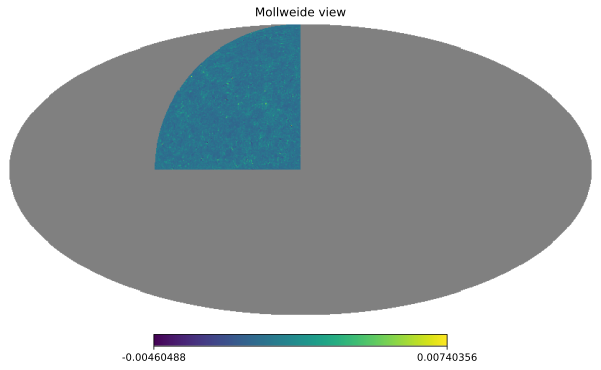

In [4]:
hp.mollview(kappa_octant)

The following code allows us to remove patches from an input kappa map (a Takahashi map in this case). This patch is then moved across the sky to generate a full jackknife sample

In [5]:
npix = len(kappa_octant)
nside_patch = 4
npatch = hp.nside2npix(nside_patch)

print(f'generating {hp.nside2npix(nside_patch)} jackknife samples')

ith_pixel_patch = get_patches(npix, nside_patch)

generating 192 jackknife samples


Here we are plotting an illustration of the different patches that are removed throughout the jackknife sample

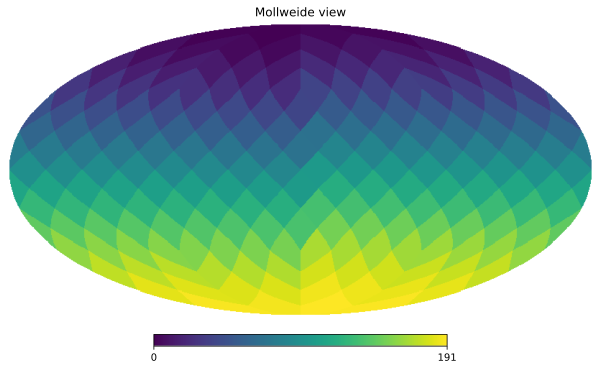

In [6]:
hp.mollview(ith_pixel_patch)

Now we perform the jackknifing on the convergence map, by looping over all patches. Note that the function implemented here does this for one patch at a time within the for loop, allowing for easy modification to save memory. 

In [12]:
#kappa_octant_jackknife_array = np.zeros([npatch, npix])
good_patch_counter=0

#set pdf bins
#lower = -0.101
#upper = 0.101
#nbins = 200
lower = -0.005
upper = 0.005
nbins = 20
bins_fine=np.linspace(-0.005,0.005,21) 

binMid,binEdges = get_bins(lower, upper, nbins, return_edges =True)


PDF, _ = np.histogram(kappa_octant, binEdges, density=True)
PDF_jackknife = np.zeros([npatch, nbins])


#for i in range(npatch):
for i in range(100):
    kappa_octant_jackknife = jackknife_map(kappa_octant, ith_pixel_patch, i)
    #print('Done patch'+str(i+1))
    if (np.any(kappa_octant_jackknife[mask] != kappa_octant[mask] )):
        print('Good patch'+str(i+1))
    else:
        #print('In the masked region')    
        continue
    
    good_patch_counter+=1
    
    # Now we can plot a subset of the jackknife samples to see how the patches of the sky have been removed from the data
    #hp.mollview(kappa_octant_jackknife)
    #plt.show()
    
    
    # Lensing PDF:
    PDF_jackknife[i], _ = np.histogram(kappa_octant_jackknife, binEdges, density=True)

    
# find good patches:
#good_flag = (PDF_jackknife[:,100]>0) #for 200 bins
good_flag = (PDF_jackknife[:,13]>0) # for 20 bins

#The JackKnife covariance matrix Cov_JK(X,Y) is extimated from (N_sub-1) * np.Cov(X,Y), see Norberg et al. Eq. (2).
#Therefore the error picks up a sqrt(N-1) term. 
PDF_standard_error = np.std(PDF_jackknife[good_flag,:],axis=0)
PDF_standard_deviation =  PDF_standard_error * np.sqrt(good_patch_counter-1)
    

Good patch1
Good patch5
Good patch6
Good patch13
Good patch14
Good patch15
Good patch25
Good patch26
Good patch27
Good patch28
Good patch41
Good patch42
Good patch43
Good patch44
Good patch45
Good patch57
Good patch58
Good patch59
Good patch60
Good patch73
Good patch74
Good patch75
Good patch76
Good patch77
Good patch89
Good patch90
Good patch91
Good patch92


ValueError: x and y must have same first dimension, but have shapes (50,) and (20, 0)

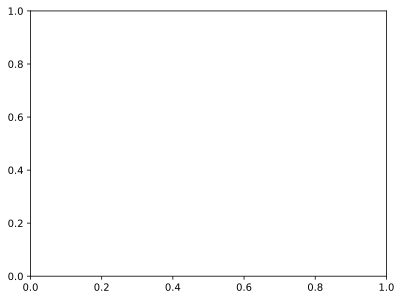

In [15]:
#plt.plot(binMid, PDF)
plt.plot(binMid, PDF_jackknife[good_flag,:].T)
plt.fill_between(binMid, PDF - PDF_standard_deviation, PDF + PDF_standard_deviation, alpha=0.5)
#plt.xlim(-0.03,0.03)
plt.xlim(-0.005,0.005)

#plt.semilogy()
plt.show()

In [24]:
# Save error bars
#np.savetxt('error_pdf_smoothed_theta3_noIA_noisy_tomo1.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_noIA_noisy_tomo1_3.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_noIA_noisefree_tomo1_3.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_noIA_noisefree_tomo3.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_noIA_noisefree_tomo1_3_20bins.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_noIA_noisefree_tomo1_20bins.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_TT_noisefree_tomo1_3_20bins.dat',PDF_standard_deviation)
np.savetxt('error_pdf_smoothed_theta3_TT_noisefree_tomo1_20bins.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_TT_noisefree_tomo3_20bins.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_TT_noisy_tomo1_3_20bins.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_TT_noisy_tomo1_20bins.dat',PDF_standard_deviation)
#np.savetxt('error_pdf_smoothed_theta3_TT_noisy_tomo3_20bins.dat',PDF_standard_deviation)


In [22]:
ls

 error_min_smoothed_theta3_noIA_noisefree_tomo1_3.dat
 error_min_smoothed_theta3_noIA_noisefree_tomo1.dat
 error_min_smoothed_theta3_noIA_noisefree_tomo3.dat
 error_min_smoothed_theta3_TT_noisefree_tomo1_3.dat
 error_min_smoothed_theta3_TT_noisefree_tomo1.dat
 error_min_smoothed_theta3_TT_noisefree_tomo3.dat
 error_pdf_smoothed_theta1_noIA_noisefree_tomo1.dat
 error_pdf_smoothed_theta3_noIA_noisefree_tomo1_20bins.dat
 error_pdf_smoothed_theta3_noIA_noisefree_tomo1_3.dat
 error_pdf_smoothed_theta3_noIA_noisefree_tomo1.dat
 error_pdf_smoothed_theta3_noIA_noisefree_tomo3_20bins.dat
 error_pdf_smoothed_theta3_noIA_noisefree_tomo3.dat
 error_pdf_smoothed_theta3_noIA_noisy_tomo1_3.dat
 error_pdf_smoothed_theta3_noIA_noisy_tomo1.dat
 error_pdf_smoothed_theta3_noIA_noisy_tomo3.dat
 error_peaks_smoothed_theta3_noIA_noisefree_tomo1_3.dat
 error_peaks_smoothed_theta3_noIA_noisefree_tomo1.dat
 error_peaks_smoothed_theta3_noIA_noisefree_tomo3.dat
 error_peaks_smoothed_theta3_noIA_noisy_tomo1_3.dat


In [45]:
# Peaks and minima
# Find extremas in the full sample and in the jackknife patches:

# Peaks or minima?
minima=True

extrema_pos, extrema_amp, extrema_pos_jackknife, extrema_amp_jackknife = find_extrema_jackknife(kappa_octant, nside_patch, minima=minima)

# Compute histograms (i.e. peak count) and get error bars:
#set peak abundance bins

#noise-free setting, peaks:
#lower = -0.01
#upper = 0.06

#noisy settings, peaks&minima:
#noisefree settings, minima
lower = -0.01
upper = 0.005


nbins = 50
binMid,binEdges = get_bins(lower, upper, nbins, return_edges =True)

good_jackknife = np.zeros([npatch],dtype=bool)
for i in range(npatch):
    good_jackknife[i] = len(extrema_amp_jackknife[i]) != len(extrema_amp)
    
extrema_pos_jackknife_good = []
extrema_amp_jackknife_good = []
for i, i_bool in enumerate(good_jackknife):
    if i_bool:
        extrema_pos_jackknife_good.append(extrema_pos_jackknife[i])
        extrema_amp_jackknife_good.append(extrema_amp_jackknife[i])

peak_abundance, _ = np.histogram(extrema_amp, binEdges)
peak_abundance_jackknife = np.zeros([npatch, nbins])
for i in range(good_jackknife.sum()):
    peak_abundance_jackknife[i], _ = np.histogram(extrema_amp_jackknife_good[i], binEdges)
    
# Find tiles that are in the octant:   
if(minima):
    #good_flag = (peak_abundance_jackknife[:,7]>0)    
    good_flag = (peak_abundance_jackknife[:,20]>0)    
else:
    good_flag = (peak_abundance_jackknife[:,20]>0)    
    
    
peak_abundance_standard_error = np.std(peak_abundance_jackknife[good_flag,:],axis=0)
peak_abundance_standard_deviation = np.std(peak_abundance_jackknife[good_flag,:],axis=0) * np.sqrt(np.sum(good_jackknife)-1) # is that the correct JK equation?

number of minima identified: 20420


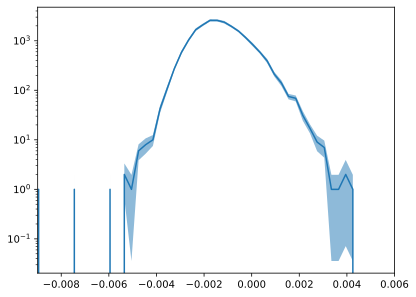

In [46]:
plt.plot(binMid, peak_abundance)
plt.fill_between(binMid, peak_abundance - peak_abundance_standard_deviation, peak_abundance + peak_abundance_standard_deviation, alpha=0.5)
plt.semilogy()
plt.xlim(-0.00899,0.006)
plt.show()

if(minima):
    #np.savetxt('error_peaks_smoothed_theta3_noIA_noisy_tomo1_3.dat',peak_abundance_standard_deviation)
    #np.savetxt('error_min_smoothed_theta3_noIA_noisefree_tomo3.dat',peak_abundance_standard_deviation)
    #np.savetxt('error_min_smoothed_theta3_noIA_noisefree_tomo1_3.dat',peak_abundance_standard_deviation)
    np.savetxt('error_min_smoothed_theta3_TT_noisefree_tomo3_V2.dat',peak_abundance_standard_deviation)
    #np.savetxt('error_min_smoothed_theta3_TT_noisy_tomo3.dat',peak_abundance_standard_deviation)
    #np.savetxt('error_min_smoothed_theta3_TT_noisy_tomo1_3.dat',peak_abundance_standard_deviation)
else:
    #np.savetxt('error_peaks_smoothed_theta3_noIA_noisy_tomo1_3.dat',peak_abundance_standard_deviation)
    np.savetxt('error_peaks_smoothed_theta3_noIA_noisefree_tomo1.dat',peak_abundance_standard_deviation)

In [43]:
good_flag = (peak_abundance_jackknife[:,20]>0)    


In [27]:

peak_abundance_standard_error = np.std(peak_abundance_jackknife[good_flag,:],axis=0)
peak_abundance_standard_deviation = np.std(peak_abundance_jackknife[good_flag,:],axis=0) * np.sqrt(np.sum(good_jackknife)-1) # is that the correct JK equation?

In [44]:
good_flag

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [34]:
peak_abundance_jackknife[:,7]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [25]:
np.max(PDF_jackknife)

302.55131416376145

In [74]:
np.max(PDF_jackknife[good_flag,:])

251.43058507766645

In [72]:
good_flag=(PDF_jackknife[:,100]>0)

In [75]:
np.shape(peak_abundance_jackknife)

(192, 50)

In [76]:
(peak_abundance_jackknife[:,20]>0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [29]:
PDF_jackknife[:,13]

array([96.7242975 ,  0.        ,  0.        ,  0.        , 97.92819369,
       97.25431182,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 96.57903428, 97.83913237, 96.34785612,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 96.964537  ,
       97.24838883, 96.60524351, 96.73354241,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       97.47371016, 96.14542241, 96.98522404, 96.99868184, 97.19599104,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 97.12951049, 97.12951592, 97.24680924, 96.69035411,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

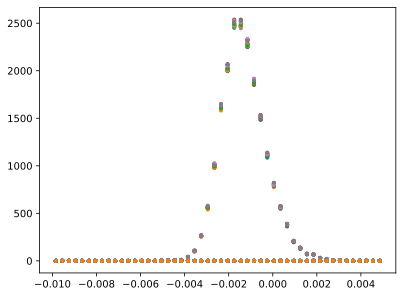

In [38]:
for i in range(0,192):
    plt.plot(binMid, peak_abundance_jackknife[i,:],'.')
plt.show()
